## RD900 region - identification of duplication events in MTBC

**Objective:**

Identify duplication events in RD900 MTBC using available genome assemblies.

**Method:**

1. identify assemblies to use including sub-sampling MTB an Mbovis genomes by choosing best qualities
2. decide which sub sequences we want to use to detect presence of a gene in contigs
3. for each assembly:
    * make a blast database
    * blast sub-sequence(s) to it
    * store result
4. make a matrix of presence absence for each genome
5. make a species tree and use the matrix to determine parsimony

**Links:**

* https://github.com/dmnfarrell/rd900


<img src="img/pknh_orthologs.png" width=500></img>

In [14]:
import os, glob, subprocess
import urllib
from importlib import reload
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from BCBio import GFF
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import tools
pd.set_option("display.width",140)

In [27]:
#samples = pd.read_csv('genomes_data.csv')
assemblies = pd.read_csv('mtb_assemblies.csv')
assemblies[-4:]

,Organism_Name,Strain,CladeID,BioSample,BioProject,Group,SubGroup,Assembly,Size (Mb),GC%,...,Scaffolds,Genes,Proteins,Release Date,Modify Date,Level,RefSeq FTP,GenBank FTP,species,Assembly_nover
6596,Mycobacterium marinum,DE4576,20835,SAMN07811431,PRJNA414948,Terrabacteria group,Actinobacteria,GCA_003431805.1,6.4167,65.8,...,133.0,5561,5291,2018/08/29,2018/09/02,Scaffold,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/003...,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/003...,marinum,GCA_003431805
6597,Mycobacterium orygis,ASM638503v1,20835,SAMN11890852,PRJNA545406,Terrabacteria group,Actinobacteria,GCA_006385035.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Scaffold,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/006...,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/006...,orygis,GCA_006385035
6598,Mycobacterium orygis,Morygis1.0,20835,SAMN02470820,PRJNA193095,Terrabacteria group,Actinobacteria,GCA_000353205.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Scaffold,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,orygis,GCA_000353205
6599,Mycobacterium liflandii,128FXT,20835,SAMN02603618,PRJNA20227,Terrabacteria group,Actinobacteria,GCA_000026445.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Complete Genome,NaN,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,liflandii,GCA_000026445


### Filter assemblies to use

In [130]:
filtered=assemblies[(assemblies.Level=='Complete Genome') | (~assemblies.species.isin(['mtb']))]
omit = ['PRJNA407834','PRJNA287158','PRJNA214551']
filtered = filtered[~filtered.BioProject.isin(omit)]

filtered = filtered[(filtered.species!='marinum')]
print (len(filtered),len(assemblies))
print (filtered.species.value_counts())
#print (filtered.columns)
#print (filtered.BioProject.value_counts())

230 6600
mtb           87
BCG           37
africanum     31
bovis         28
canettii       9
H37Rv          9
CDC            7
ulcerans       7
H37Ra          3
pinnipedii     3
microti        3
caprae         3
orygis         2
liflandii      1
Name: species, dtype: int64


### test data fetch

In [4]:
url = assemblies.loc[0]['GenBank FTP']
link = tools.get_url_from_path(url)
name = 'GCA_000934325.3'
urllib.request.urlretrieve(link, os.path.join('assemblies', name+'.fa.gz'))

('assemblies/GCA_000934325.3.fa.gz', <email.message.Message at 0x7f81485b6160>)

### make local blast database

In [22]:
def make_blast_db(infile, out='test'):
    
    cmd = 'gunzip -c {i} | makeblastdb -in - -dbtype nucl -out blastdb/{o} -title test'.format(i=infile,o=out)
    subprocess.check_output(cmd, shell=True)
    return

#make_blast_db('assemblies/GCA_000934325.3.fa.gz')

### determine sequences to blast using sub sequences within africanum RD900 region

In [25]:
rd900seq = SeqIO.read('RD900MAF.fa',format='fasta')
pknh1 = rd900seq[783:2663]
pknh1.id = 'pknh1'
tbd2 = rd900seq[2907:5303]
tbd2.id = 'tbd2'
pknh2 = rd900seq[5314:6981]
pknh2.id='pknh2'
pro1 = rd900seq[1612:1772]
pro1.id = 'pknh1-proregion'
pknh2_sensor = rd900seq[5314:6000]
pknh2_sensor.id = 'pknh2_sensor'
print (pknh2_sensor.seq)

TACCCGTACTTGGCCCACCAGTTGTGCAGATCCTCAATGGTCGCGGGATCCCCGAAGACGTCGCTGAGCGTTAGCTTGGCCTCGTTGCTCCAGATCACGTTCGGGCGATTCTTATAGGTGCCGCACGCGATCATGCCTGCGGTCACGTCTGGGGTCTGGTTGTAATGCCAGCCATCCGGTGATGGTCCTTCACCGGGACAGTTCATCAGCTCCACGGCGGCGATATCGTCGTTGAAGGCCTGTTTCAGCTTGTCGGGATTGGCGAACAATCCATAGATGGCGCGACTTGGCCCACCCTGGTTGGTGTTTTGCCCGCAGTCGACCATCGCCACGGCGTTCACCCATATGCTGTTCGGCTTCGGCGTGGTCGGTTTACAGGTGCCGGTCGGATAGCCCGACGGCAACATGCTGAGCAGCCTGGTCTGCGGGTCGCTGGCCGGTGCTGTGGTCGGCGTTGTGGTCGCGGGTAGCGAGGTCGTTGCCGTGGTGGTGGGGGTGCCTGGGGAGGTCGCGATGTTCCGTTTTGGGTTGTCGTCCGGTCGGTTGGCGATCCAGATGCCGATGGCGCCCAACACGAGGACGAGCACGACGGCGGCGGCGACGGCCACAAAGGGCCACGGGTTCGTTTTGCGTGGGGTCTGGGCCCAGGGGCTGGGGCCGCCGGACGGCGGTGCGCCCCAGCCGCC


### loop over assemblies and get results

Here we loop over each assembly in the table and fetch the file remotely, make a blast db and 

In [ ]:
def run(seqs, df):
    result=[]
    for i,row in df.iterrows():
        acc = row.Assembly
        strain = row.Strain
        species = row.species
        full = row.Organism_Name
        print (strain, acc)
        url = row['GenBank FTP']
        #get file
        filename = os.path.join('assemblies', acc+'.fa.gz')
        dbname = 'blastdb/%s.nsq' %acc
        if not os.path.exists(filename):
            link = tools.get_url_from_path(url)            
            urllib.request.urlretrieve(link, filename)
            #make blast database for this genome
            make_blast_db(filename, out=acc)
        data={}
        for seq in seqs:
            #do blast
            bl = tools.blast_sequences('blastdb/%s' %acc, seq)
            bl['pcov'] = bl.length/len(seq)
            #print (bl)
            bl = bl[bl.pcov>.50]
            if len(bl)>0:
                x = bl.iloc[0]                
                ident = x.pident
            else:
                ident = 0
            data[seq.id] = ident
        data['id'] = row.Assembly_nover
        data['strain'] = strain
        data['species'] = species
        data['name'] = full
        result.append(data)

    result = pd.DataFrame(result)
    return result 

seqs = [pknh1,tbd2,pro1,pknh2_sensor]
result = run(seqs, filtered[:60] )
result.to_csv('rd900_region_hits.csv',index=False)

In [ ]:
result = pd.read_csv('rd900_region_hits.csv')
X=result.set_index(['species','strain']).drop(columns=['name','id'])
sns.clustermap(X,cmap='gray_r',yticklabels=1,figsize=(5,20))

### Species tree with ANIs

pyani: `average_nucleotide_identity.py -o ANIm_out -i temp -m ANIm -f` (too slow)

fastANI: `fastANI --ql reference.txt --rl query.txt -o fastani.out -t 10`

https://github.com/ParBLiSS/FastANI.git

### make file lists for FastANI

In [174]:
names = list(filtered.Assembly_nover)[:60]
l=[]
for f in glob.glob('assemblies/*.fa.gz'):
    n=os.path.basename(f).split('.')[0]
    if n in names:
        l.append(f)
#print (l)
with open('query.txt', 'w') as infile:
    infile.write('\n'.join(l))
shutil.copyfile('query.txt','reference.txt')

'reference.txt'

## run fastANI

In [176]:
#anim = pd.read_csv('ANIm_out/ANIm_percentage_identity.tab',sep='\t',index_col=0)
def get_fastani():
    import re
    df = pd.read_csv('fastani.out',sep='\t',names=['query','ref','ident','x','y'])
    df['query'] = df['query'].apply(lambda x: re.split(r"[\./]+",x)[1])
    df['ref'] = df['ref'].apply(lambda x: re.split(r"[\./]+",x)[1])
    x = pd.pivot_table(df,index='query',values='ident',columns=['ref'])
    return x

cmd = 'fastANI --ql reference.txt --rl query.txt -o fastani.out -t 10'
subprocess.check_output(cmd,shell=True)

b''

In [186]:
anim = get_fastani()
#anim

In [187]:
df = filtered.set_index('Assembly_nover').species
mapping = df.to_dict()
#anim.columns.map(mapping)
#anim.index = anim.index.map(mapping)
anim.to_csv('anim_matrix.csv')
#anim

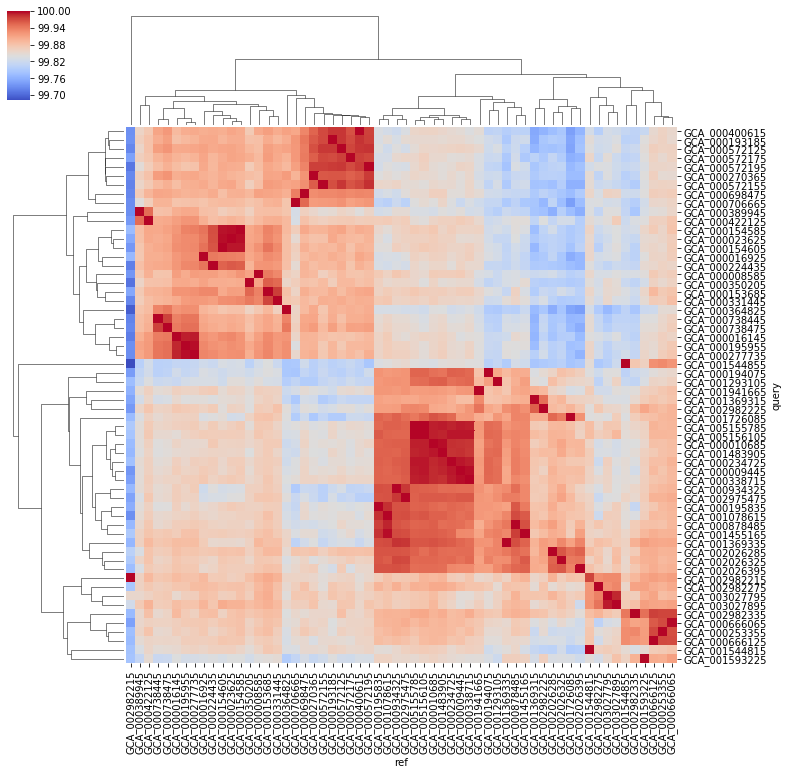

In [188]:
cl=sns.clustermap(anim,xticklabels=1,yticklabels=1,cmap='coolwarm',figsize=(12,12))
cl.savefig('anim_clustermap.png',dpi=150)